In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from multiprocessing import Pool
import itertools

# Load Data

In [4]:
# Daten laden
data = pd.read_csv('data_team8.csv')

# Zeit- und Sonnenfleckendaten extrahieren
time = data['Time'].values
sn = data['SN'].values

# Check num values of data
print('time values: ', time.size)
print('sn values: ', sn.size)

time values:  39980
sn values:  39980


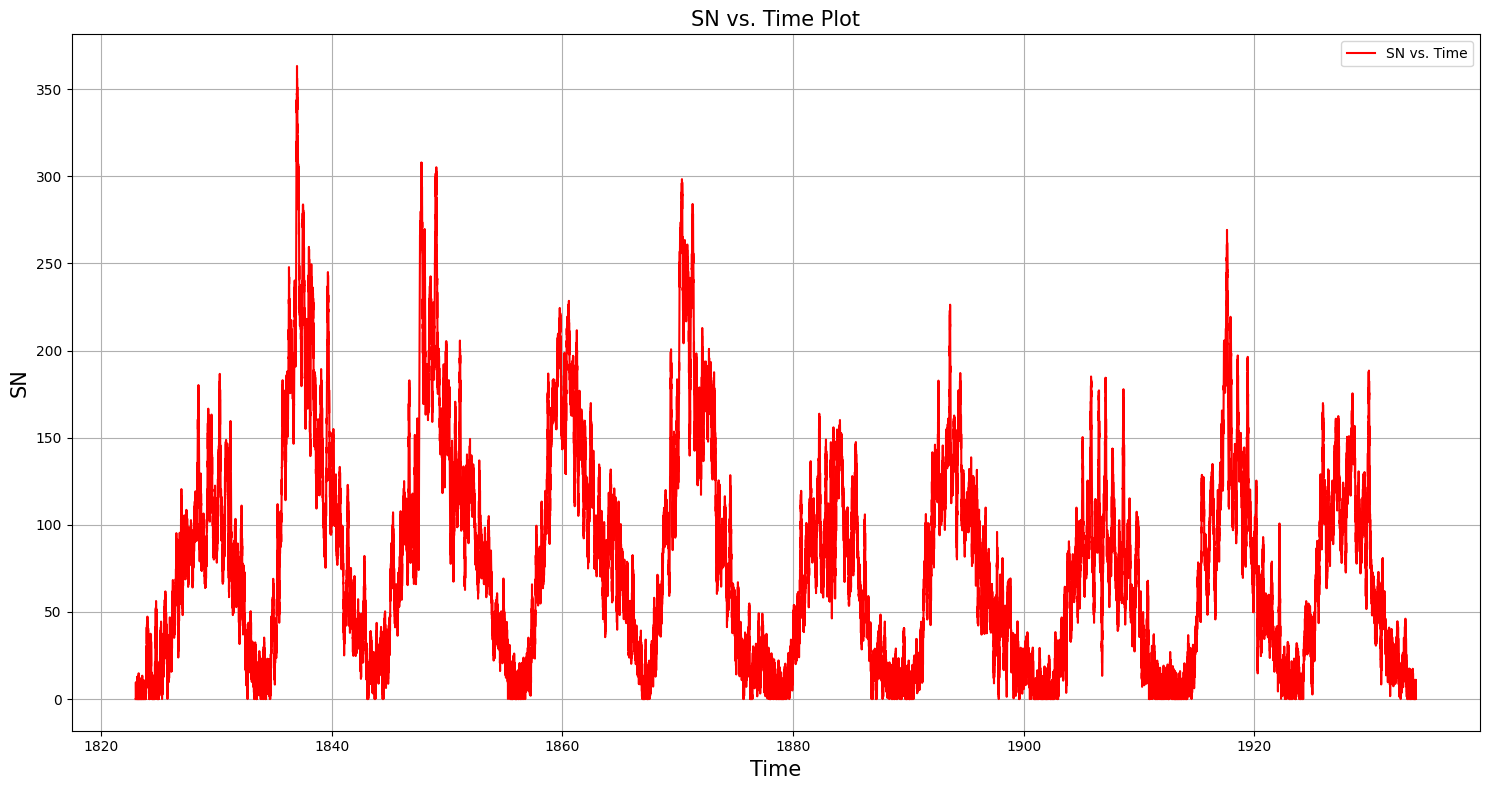

In [5]:
# Plot the data
plt.figure(figsize=(15, 8))
plt.plot(time, sn, linestyle='-', color='r', label='SN vs. Time')

# Customize the plot
plt.title("SN vs. Time Plot", fontsize=15)
plt.xlabel("Time", fontsize=15)
plt.ylabel("SN", fontsize=15)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [4]:
# Downsample the data
factor = 10
downsampled_time = time[::factor]
downsampled_sn = sn[::factor]

# Check num values of downsampled data
print('time values: ', downsampled_time.size)
print('sn values: ', downsampled_sn.size)

time values:  3998
sn values:  3998


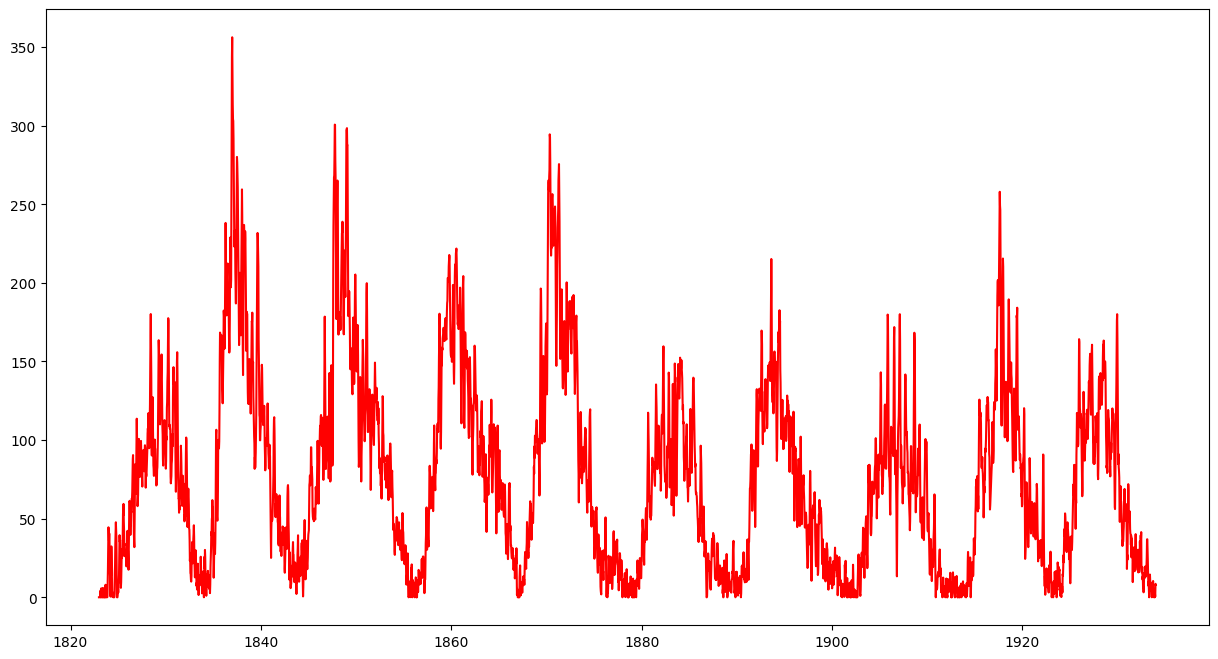

In [5]:
# Plot downsampled data
plt.figure(figsize=(15, 8))
plt.plot(downsampled_time, downsampled_sn, linestyle='-', color='r', label='SN vs. Time')


# Model and Loss Functions

In [6]:
# Model for all solar cycles
def solar_model(t, params):
    if len(params) != 30:
        raise ValueError("Expected 30 parameters (10 cycles), got {len(params)}.")
    x = np.zeros_like(t)
    for k in range(10):  # 10 cycles
        T0_k, Ts_k, Td_k = params[3 * k: 3 * k + 3]

        # Enforce minimum thresholds for stability
        Ts_k = max(Ts_k, 1e-6)  # Avoid division by zero
        Td_k = max(Td_k, 1e-6)  # Avoid division by zero

        if k < 9:
            T0_next = params[3 * (k + 1)]
            mask = (t >= T0_k) & (t < T0_next)
        else:
            mask = (t >= T0_k)
        x[mask] += ((t[mask] - T0_k) / Ts_k) ** 2 * np.exp(-((t[mask] - T0_k) / Td_k) ** 2)
    return x

# Loss function (MSE)
def mse(params):
    predictions = solar_model(time, params)
    return np.mean((sn - predictions) ** 2)

## Simulated Annealing (SA) Algorithm

In [7]:
# Simulated Annealing Algorithm
def simulated_annealing(x0, T0, sigma, f, n_iter=20000):
    x = x0.copy()
    T = T0
    n_params = len(x0)
    means = np.zeros(n_params)
    cov_matrix = np.diag(np.full(n_params, sigma))
    mse_values = []

    for iter_counter in range(n_iter):
        x_old = x.copy()
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        x_proposal = np.clip(x_proposal, a_min=0, a_max=np.inf)  # Enforce positivity
        DeltaE = f(x_proposal) - f(x_old)

        if np.exp(-np.clip(DeltaE / T, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old

        T = T0 * (1 - iter_counter / n_iter)
        mse_values.append(f(x))

    return x, mse_values

# Hyperparameter Optimization

In [8]:
# Parallelized function for hyperparameter optimization
def hyperparameter_task(params):
    T0, sigma = params
    print(f"Testing T0={T0}, sigma={sigma}")
    outSA, mse_history = simulated_annealing(x0, T0, sigma, f=mse, n_iter=20000)
    final_loss = mse(outSA)

    # Save MSE evolution plot
    plt.figure()
    plt.plot(mse_history)
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.title(f"MSE Evolution (T0={T0}, sigma={sigma})")
    plt.grid()
    plt.savefig(f"mse_T0_{T0}_sigma_{sigma}.png")
    plt.close()

    return T0, sigma, final_loss

# Model Calibration

In [9]:
# Parallelized function for independent SA runs
def calibration_task(x0_noise):
    params, _ = simulated_annealing(x0_noise, best_T0, best_sigma, f=mse, n_iter=20000)

    return params

# Complete Cluster Code (saved as Cluster.py as well)

In [ ]:
import numpy as np
import os
import time  # For measuring runtime
from multiprocessing import Pool
import matplotlib.pyplot as plt
import itertools

# -------------------------------
# Model Functions and Loss
# -------------------------------

# Model for all solar cycles
def solar_model(t, params):
    if len(params) != 30:
        raise ValueError("Expected 30 parameters (10 cycles), got {len(params)}.")
    x = np.zeros_like(t)
    for k in range(10):  # 10 cycles
        T0_k, Ts_k, Td_k = params[3 * k: 3 * k + 3]

        # Enforce minimum thresholds for stability
        Ts_k = max(Ts_k, 1e-6)  # Avoid division by zero
        Td_k = max(Td_k, 1e-6)  # Avoid division by zero

        if k < 9:
            T0_next = params[3 * (k + 1)]
            mask = (t >= T0_k) & (t < T0_next)
        else:
            mask = (t >= T0_k)
        x[mask] += ((t[mask] - T0_k) / Ts_k) ** 2 * np.exp(-((t[mask] - T0_k) / Td_k) ** 2)
    return x

# Loss function (MSE)
def mse(params):
    predictions = solar_model(time_data, params)
    return np.mean((sn - predictions) ** 2)

# -------------------------------
# Simulated Annealing Algorithm
# -------------------------------

def simulated_annealing(x0, T0, sigma, f, n_iter=20000):
    x = x0.copy()
    T = T0
    n_params = len(x0)
    means = np.zeros(n_params)
    cov_matrix = np.diag(np.full(n_params, sigma))
    mse_values = []

    for iter_counter in range(n_iter):
        x_old = x.copy()
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        x_proposal = np.clip(x_proposal, a_min=0, a_max=np.inf)  # Enforce positivity
        DeltaE = f(x_proposal) - f(x_old)

        if np.exp(-np.clip(DeltaE / T, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old

        T = T0 * (1 - iter_counter / n_iter)
        mse_values.append(f(x))

    return x, mse_values

# -------------------------------
# Hyperparameter Optimization
# -------------------------------

# Parallelized function for hyperparameter optimization
def hyperparameter_task(params):
    T0, sigma = params
    print(f"Testing T0={T0}, sigma={sigma}")
    outSA, mse_history = simulated_annealing(x0, T0, sigma, f=mse, n_iter=20000)
    final_loss = mse(outSA)

    # Save MSE evolution plot
    plt.figure()
    plt.plot(mse_history)
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.title(f"MSE Evolution (T0={T0}, sigma={sigma})")
    plt.grid()
    plt.savefig(f"mse_T0_{T0}sigma{sigma}.png")
    plt.close()

    return T0, sigma, final_loss

# -------------------------------
# Model Calibration
# -------------------------------

# Parallelized function for independent SA runs
def calibration_task(x0_noise):
    params, _ = simulated_annealing(x0_noise, best_T0, best_sigma, f=mse, n_iter=20000)
    return params

# -------------------------------
# Main Script for Cluster
# -------------------------------

if __name__ == "__main__":
    # Start time measurement
    total_start_time = time.time()

    # Load data
    data = np.loadtxt("data_team8.csv", delimiter=",", skiprows=1)
    time_data = data[:, 0]
    sn = data[:, 1]

    # Initial parameters
    initial_T0 = [1823.3, 1833.9, 1843.5, 1856.0, 1867.2, 1878.9, 1889.6, 1901.7, 1913.6, 1923.6]
    initial_Ts = [0.3] * 10
    initial_Td = [5.0] * 10
    x0 = []
    for i in range(10):
        x0.extend([initial_T0[i], initial_Ts[i], initial_Td[i]])
    x0 = np.array(x0)

    # Hyperparameter grid
    T0_values = np.linspace(0, 10, 10)
    sigma_values = np.linspace(10**-9, 10**-6, 10)
    hyperparameters = list(itertools.product(T0_values, sigma_values))

    # Task 1: Hyperparameter Optimization
    with Pool(32) as pool:
        results = pool.map(hyperparameter_task, hyperparameters)
    results_sorted = sorted(results, key=lambda x: x[2])
    best_T0, best_sigma, _ = results_sorted[0]
    print(f"Best Hyperparameters: T0={best_T0}, Sigma={best_sigma}")

    # Task 2: Model Calibration
    noisy_initial_conditions = [x0 + np.random.normal(0, 0.1, size=30) for _ in range(10)]
    with Pool(10) as pool:
        calibration_results = pool.map(calibration_task, noisy_initial_conditions)

    # Combine results: Center of Mass
    calibration_results = np.array(calibration_results)
    center_of_mass = np.mean(calibration_results, axis=0)
    print("Final Optimized Parameters (Center of Mass):", center_of_mass)

    # End time measurement
    total_runtime = time.time() - total_start_time
    print(f"Total Runtime: {total_runtime:.2f} seconds")

    # Save the final fit
    predictions = solar_model(time_data, center_of_mass)
    plt.figure()
    plt.plot(time_data, sn, label="Original Data", color="orange")
    plt.plot(time_data, predictions, label="Optimized Fit", color="blue")
    plt.xlabel("Year")
    plt.ylabel("SN")
    plt.legend()
    plt.title("Final Optimized Fit")
    plt.grid()
    plt.savefig("final_optimized_fit.png")
    plt.show()

    # Combine results: MSE values from all calibration runs
    mse_calibration_results = [mse(params) for params in calibration_results]
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(mse_calibration_results)), mse_calibration_results, marker='o', label="Calibration MSE")
    plt.xlabel("Run Index")
    plt.ylabel("Final MSE")
    plt.title("Final MSE for Each Calibration Run")
    plt.grid()
    plt.legend()
    plt.savefig("calibration_mse_summary.png")
    plt.show()

    # Linear correlation between T_S and T_d
    Ts = center_of_mass[1::3]
    Td = center_of_mass[2::3]
    slope, intercept = np.polyfit(Ts, Td, 1)
    Td_fit = slope * Ts + intercept

    plt.figure()
    plt.scatter(Ts, Td, label="T_S vs T_d", color="orange")
    plt.plot(Ts, Td_fit, label=f"Linear Fit: slope={slope:.2f}, intercept={intercept:.2f}", color="blue")
    plt.xlabel("T_S")
    plt.ylabel("T_d")
    plt.title("Linear Correlation Between T_S and T_d")
    plt.legend()
    plt.grid()
    plt.savefig("linear_correlation_Ts_Td.png")
    plt.show()

# Parallelized run (executed on Cluster)

In [ ]:
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt
import time

# -------------------------------
# Model Functions and Loss
# -------------------------------

def solar_model(t, params):
    if len(params) != 30:
        raise ValueError(f"Expected 30 parameters (10 cycles), got {len(params)}.")
    x = np.zeros_like(t)
    for k in range(10):  # 10 cycles
        T0_k, Ts_k, Td_k = params[3 * k: 3 * k + 3]
        Ts_k = max(Ts_k, 1e-6)  # Avoid division by zero
        Td_k = max(Td_k, 1e-6)  # Avoid division by zero
        if k < 9:
            T0_next = params[3 * (k + 1)]
            mask = (t >= T0_k) & (t < T0_next)
        else:
            mask = (t >= T0_k)
        x[mask] += ((t[mask] - T0_k) / Ts_k) ** 2 * np.exp(-((t[mask] - T0_k) / Td_k) ** 2)
    return x

def mse(params):
    predictions = solar_model(time_data, params)
    return np.mean((sn - predictions) ** 2)

# -------------------------------
# Simulated Annealing Algorithm
# -------------------------------

def simulated_annealing(x0, T0, sigma, f, n_iter=20000):
    x = x0.copy()
    T = T0
    n_params = len(x0)
    means = np.zeros(n_params)
    cov_matrix = np.diag(np.full(n_params, sigma))
    mse_values = []

    for iter_counter in range(n_iter):
        x_old = x.copy()
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        x_proposal = np.clip(x_proposal, a_min=0, a_max=np.inf)  # Enforce positivity
        DeltaE = f(x_proposal) - f(x_old)
        if np.exp(-np.clip(DeltaE / T, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        T = T0 * (1 - iter_counter / n_iter)
        mse_values.append(f(x))

    return x, mse_values

# -------------------------------
# Hyperparameter Task
# -------------------------------

def hyperparameter_task(params):
    T0, sigma = params
    print(f"Testing T0={T0}, sigma={sigma}")
    outSA, mse_history = simulated_annealing(x0, T0, sigma, f=mse, n_iter=20000)
    final_loss = mse(outSA)
    return T0, sigma, final_loss

# -------------------------------
# Main Script
# -------------------------------

if __name__ == "__main__":
    # Load data
    data = np.loadtxt("data_team8.csv", delimiter=",", skiprows=1)
    time_data = data[:, 0]
    sn = data[:, 1]

    # Initial parameters
    initial_T0 = [1823.3, 1833.9, 1843.5, 1856.0, 1867.2, 1878.9, 1889.6, 1901.7, 1913.6, 1923.6]
    initial_Ts = [0.3] * 10
    initial_Td = [5.0] * 10
    x0 = []
    for i in range(10):
        x0.extend([initial_T0[i], initial_Ts[i], initial_Td[i]])
    x0 = np.array(x0)

    # Define 4 hyperparameter pairs
    hyperparameter_pairs = [
        (1.0, 1e-7),
        (1.1, 1e-7),
        (1.0, 1e-6),
        (1.1, 1e-6),
    ]

    # -------------------------------
    # Parallelized Execution
    # -------------------------------
    print("Starting parallelized execution...")
    start_time = time.time()

    # Use multiprocessing for parallelization
    with Pool(4) as pool:  # Number of workers matches the number of tasks
        parallel_results = pool.map(hyperparameter_task, hyperparameter_pairs)

    parallel_runtime = time.time() - start_time
    
     # Save runtime to a variable or file
    with open("parallel_runtime.txt", "w") as f:
        f.write(f"Parallelized Execution Time Execution Time: {parallel_runtime:.2f} seconds\n")

    print(f"Non-Parallelized Execution Time: {parallel_runtime:.2f} seconds")


Starte Python-Skript...

Starting parallelized execution...

Parallelized Execution Time: 87.48 seconds

Parallelized Results: [(1.0, 1e-07, np.float64(804.9153168246223)), (1.1, 1e-07, np.float64(837.1187781781363)), (1.0, 1e-06, np.float64(669.0315427336028)), (1.1, 1e-06, np.float64(677.9404268660155))]

# Non-parallel run

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import time

# -------------------------------
# Model Functions and Loss
# -------------------------------

def solar_model(t, params):
    if len(params) != 30:
        raise ValueError(f"Expected 30 parameters (10 cycles), got {len(params)}.")
    x = np.zeros_like(t)
    for k in range(10):  # 10 cycles
        T0_k, Ts_k, Td_k = params[3 * k: 3 * k + 3]
        Ts_k = max(Ts_k, 1e-6)  # Avoid division by zero
        Td_k = max(Td_k, 1e-6)  # Avoid division by zero
        if k < 9:
            T0_next = params[3 * (k + 1)]
            mask = (t >= T0_k) & (t < T0_next)
        else:
            mask = (t >= T0_k)
        x[mask] += ((t[mask] - T0_k) / Ts_k) ** 2 * np.exp(-((t[mask] - T0_k) / Td_k) ** 2)
    return x

def mse(params):
    predictions = solar_model(time_data, params)
    return np.mean((sn - predictions) ** 2)

# -------------------------------
# Simulated Annealing Algorithm
# -------------------------------

def simulated_annealing(x0, T0, sigma, f, n_iter=20000):
    x = x0.copy()
    T = T0
    n_params = len(x0)
    means = np.zeros(n_params)
    cov_matrix = np.diag(np.full(n_params, sigma))
    mse_values = []

    for iter_counter in range(n_iter):
        x_old = x.copy()
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        x_proposal = np.clip(x_proposal, a_min=0, a_max=np.inf)  # Enforce positivity
        DeltaE = f(x_proposal) - f(x_old)
        if np.exp(-np.clip(DeltaE / T, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        T = T0 * (1 - iter_counter / n_iter)
        mse_values.append(f(x))

    return x, mse_values

# -------------------------------
# Hyperparameter Task
# -------------------------------

def hyperparameter_task(params):
    T0, sigma = params
    print(f"Testing T0={T0}, sigma={sigma}")
    outSA, mse_history = simulated_annealing(x0, T0, sigma, f=mse, n_iter=20000)
    final_loss = mse(outSA)

    # Remove the PNG generation part
    # You can keep mse_history in memory or log it if needed
    # Example: Save results in a dictionary or list
    result = {
        "T0": T0,
        "sigma": sigma,
        "final_loss": final_loss,
        "mse_history": mse_history[-10:],  # Optionally save the last 10 values for analysis
    }

    return result

# -------------------------------
# Main Script
# -------------------------------

if __name__ == "__main__":
    # Load data
    data = np.loadtxt("data_team8.csv", delimiter=",", skiprows=1)
    time_data = data[:, 0]
    sn = data[:, 1]

    # Initial parameters
    initial_T0 = [1823.3, 1833.9, 1843.5, 1856.0, 1867.2, 1878.9, 1889.6, 1901.7, 1913.6, 1923.6]
    initial_Ts = [0.3] * 10
    initial_Td = [5.0] * 10
    x0 = []
    for i in range(10):
        x0.extend([initial_T0[i], initial_Ts[i], initial_Td[i]])
    x0 = np.array(x0)

    # Define 4 hyperparameter pairs
    hyperparameter_pairs = [
        (1.0, 1e-7),
        (1.1, 1e-7),
        (1.0, 1e-6),
        (1.1, 1e-6),
    ]

    # -------------------------------
    # Non-Parallelized Execution
    # -------------------------------
    print("Starting non-parallelized execution...")
    start_time = time.time()

    # Sequential execution of tasks
    non_parallel_results = []
    for params in hyperparameter_pairs:
        result = hyperparameter_task(params)
        non_parallel_results.append(result)

    non_parallel_runtime = time.time() - start_time

    # Save runtime to a variable or file
    with open("non_parallel_runtime.txt", "w") as f:
        f.write(f"Non-Parallelized Execution Time: {non_parallel_runtime:.2f} seconds\n")

    print(f"Non-Parallelized Execution Time: {non_parallel_runtime:.2f} seconds")


Starting non-parallelized execution...
Testing T0=1.0, sigma=1e-07
Testing T0=1.1, sigma=1e-07
Testing T0=1.0, sigma=1e-06
Testing T0=1.1, sigma=1e-06
Non-Parallelized Execution Time: 324.21 seconds


# Results

## MSE-Evolution

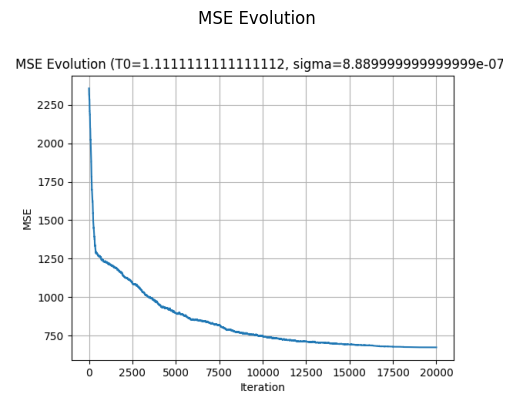

In [44]:
# Bildpfad
image_path = "MSE_Evolution.png"

# Bild laden
img = mpimg.imread(image_path)

# Bild anzeigen
plt.imshow(img)
plt.axis('off')  # Achsen ausblenden
plt.title("MSE Evolution")
plt.show()

## Final MSE für each Calibration Run

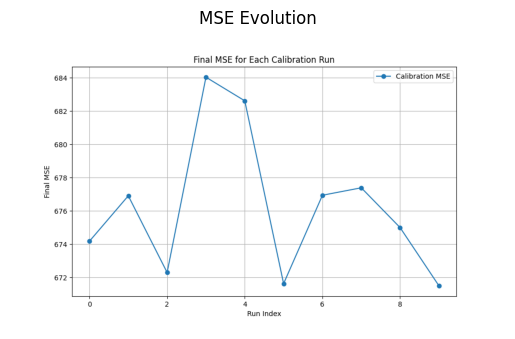

In [52]:
# Bildpfad
image_path = "calibration_mse_summary.png"

# Bild laden
img = mpimg.imread(image_path)

# Bild anzeigen
plt.imshow(img)
plt.axis('off')  # Achsen ausblenden
plt.title("MSE Evolution")
plt.show()

## Final optimized fit

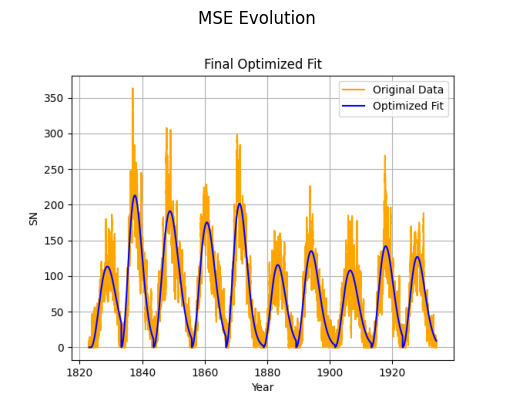

In [45]:
# Bildpfad
image_path = "final_optimized_fit.png"

# Bild laden
img = mpimg.imread(image_path)

# Bild anzeigen
plt.imshow(img)
plt.axis('off')  # Achsen ausblenden
plt.title("MSE Evolution")
plt.show()

## Linear Correlation

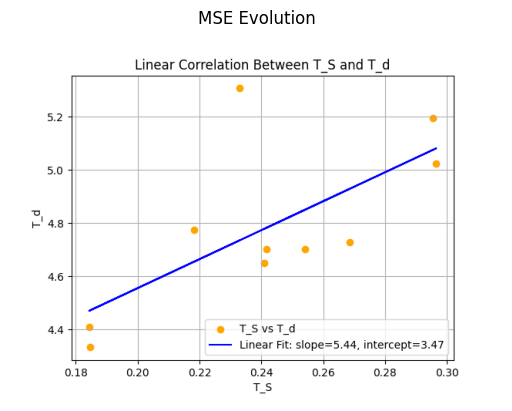

In [53]:
# Bildpfad
image_path = "linear_correlation_Ts_Td.png"

# Bild laden
img = mpimg.imread(image_path)

# Bild anzeigen
plt.imshow(img)
plt.axis('off')  # Achsen ausblenden
plt.title("MSE Evolution")
plt.show()

## Comparison parallelized and non-parallelized Attempts

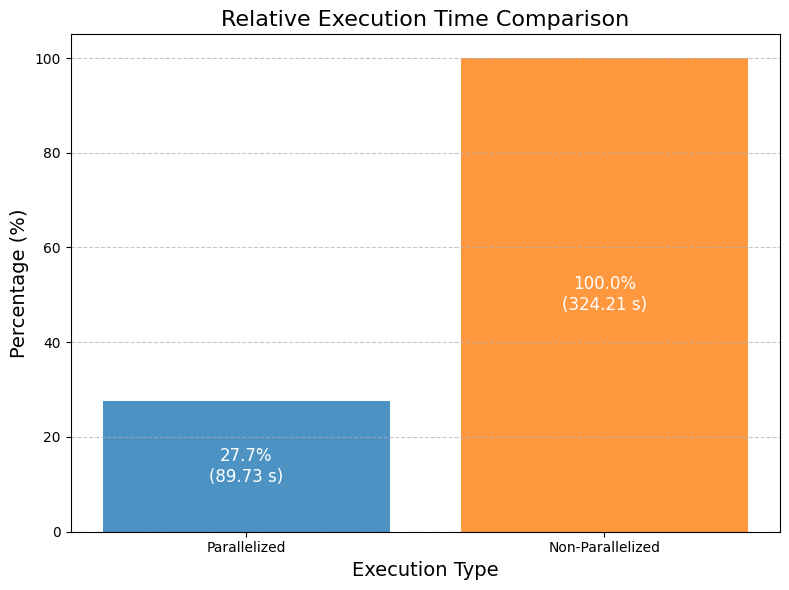

In [51]:
# Funktion zum Einlesen der Zeiten aus .txt-Dateien
def read_runtime_from_file(file_path):
    try:
        with open(file_path, "r") as file:
            line = file.readline().strip()
            # Extrahiere die Zeit aus der Textzeile
            runtime = float(line.split(":")[1].split(" ")[1])
            return runtime
    except FileNotFoundError:
        print(f"File {file_path} not found!")
        return None

# Dateien für die Laufzeiten
parallel_file = "parallel_runtime.txt"
non_parallel_file = "non_parallel_runtime.txt"

# Laufzeiten einlesen
parallel_runtime = read_runtime_from_file(parallel_file)
non_parallel_runtime = read_runtime_from_file(non_parallel_file)

# Check, ob die Laufzeiten erfolgreich eingelesen wurden
if parallel_runtime is None or non_parallel_runtime is None:
    print("Error: Could not read runtimes. Ensure the .txt files exist and are formatted correctly.")
else:
    # Zeiten in Sekunden
    execution_times = [parallel_runtime, non_parallel_runtime]
    labels = ["Parallelized", "Non-Parallelized"]

    # Prozentsatz berechnen
    percentages = [time / max(execution_times) * 100 for time in execution_times]

    # Plot erstellen
    plt.figure(figsize=(8, 6))
    colors = ["#1f77b4", "#ff7f0e"]  # Neue Farben: Blau und Orange
    bars = plt.bar(labels, percentages, color=colors, alpha=0.8)

    # Titel und Achsenbeschriftungen
    plt.title("Relative Execution Time Comparison", fontsize=16)
    plt.ylabel("Percentage (%)", fontsize=14)
    plt.xlabel("Execution Type", fontsize=14)

    # Werte innerhalb der Balken anzeigen
    for bar, pct, time in zip(bars, percentages, execution_times):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X-Position (Mitte des Balkens)
            height / 2,  # Y-Position (in der Mitte des Balkens)
            f"{pct:.1f}%\n({time:.2f} s)",  # Text (Prozentsatz und Zeit)
            ha="center", va="center", fontsize=12, color="white"
        )

    # Gitter hinzufügen
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Plot anzeigen
    plt.tight_layout()
    plt.savefig("execution_time_comparison.png")
    plt.show()
